<h1 align="center">  Домашнее задание 6 <h1 align="center"> 
<h3 align="left">  Линейное оценивание для Многих Измерений <h3 align="left"> 
<h6 align="right">  Шишкин Иван 135 группа <h6 align="right"> 
    
---

In [1]:
# импорт бибилиотек

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

from sklearn.metrics import mean_squared_error as MSE

#### 1. Моделирование измерения

**(a) Сгенерируйте случайный сигнал $x$, обладающий заданными корреляционными свойствами**

- Сгенерируйте "белый шум" $\mu \sim (0, I)$, компоненты, которого независимы и одинаково распределены $E\mu_i = 0$ и $D\mu_i = 1$

In [2]:
# параметры шума

E_mu = 0
D_mu = 1
M = 100 # размерность сигнала

In [3]:
# генерируем сигнал

mu = np.random.normal(E_mu, D_mu, M)

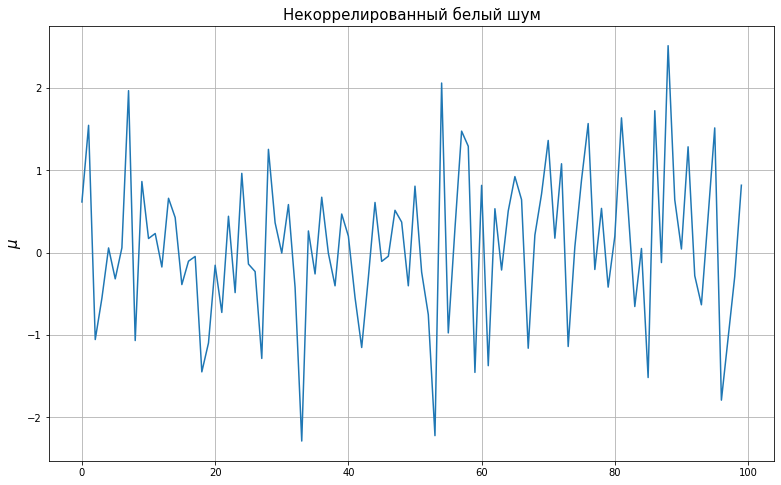

In [4]:
# график некоррелированного белого шума

fig, ax = plt.subplots(figsize=(13,8))

sns.lineplot(data=mu, ax=ax)
ax.grid()
ax.set_ylabel(r'$\mu$', fontsize=15)

ax.set_title('Некоррелированный белый шум', fontsize=15)
plt.show()

- "Сгладьте" его с помощью некоторой матрицы B


*выберем матрицу $B$ в виде Теплицевой матрицы. Чтобы операция $B\cdot\mu$ была возможна, матрица $B$ должна иметь размеры $M\times M$*

In [5]:
# создаем матрицу B

    # строка матрицы B как в примере

b_0_not_null = np.array([7 - i for i in range(7)])
b_0_null = np.zeros(M-b_0_not_null.shape[0])
b_0 = np.concatenate((b_0_not_null, b_0_null), axis=0)

    # матрица B
    
B = scipy.linalg.toeplitz(b_0)

In [6]:
# сглаживаем сигнал 

x = B @ mu
F_ap = B @ B.T

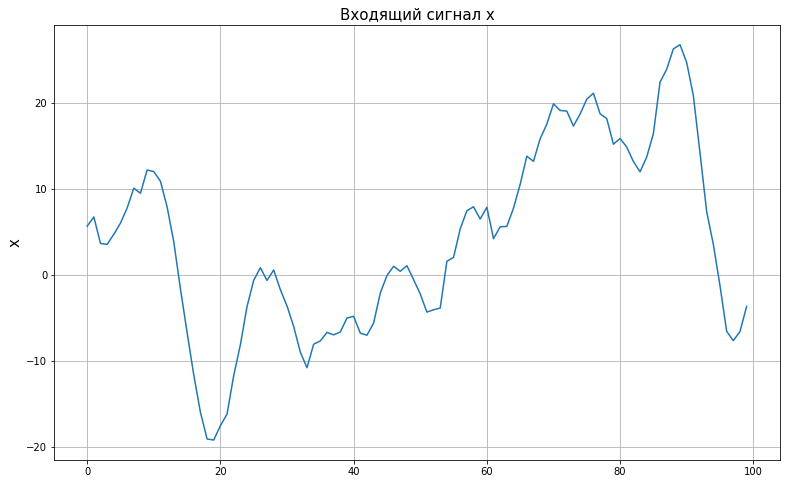

In [7]:
# график сглаженного сигнала

fig, ax = plt.subplots(figsize=(13,8))

sns.lineplot(data=x, ax=ax)
ax.grid()
ax.set_ylabel('x', fontsize=15)
ax.set_title('Входящий сигнал x', fontsize=15)
plt.show()

- Теперь сигнал $x=B\mu \sim (0,F)$, где $F=Dx=BB^T$

**(b) Постройте матрицу $A$**

*Для построения матрицы A, выберем функцию влияния точечного источника*

In [8]:
# функция для построения функции влияния точечного источника. Пригодится в пункте 3(c)

def get_spread_function(d):
    
    al = -1*d
    ar = d
    a = np.ones(ar-al+1)
    a = a/sum(a)
    
    return al, ar, a

In [9]:
# строим функцию влияния точечного источника

d = 7
al, ar, a = get_spread_function(d)

<div class="alert alert-block alert-info">
    
При построении графика функции влияния точечного источника необходимо учесть смещение по оси x (чтобы центр функция была симметрична относительно x=0). Но это сильно загромождает код + для автоматизации необходимо, чтобы этот учет проводился непосредственно в функции **get_spread_function**
    
Но так как это необходимо только для красивой отрисовки графика, а на решение задачи непосредственно не влияет, я не стал реализовывать это. Но для понимания просто отметил на графике вертикальной чертной x=0
</div>

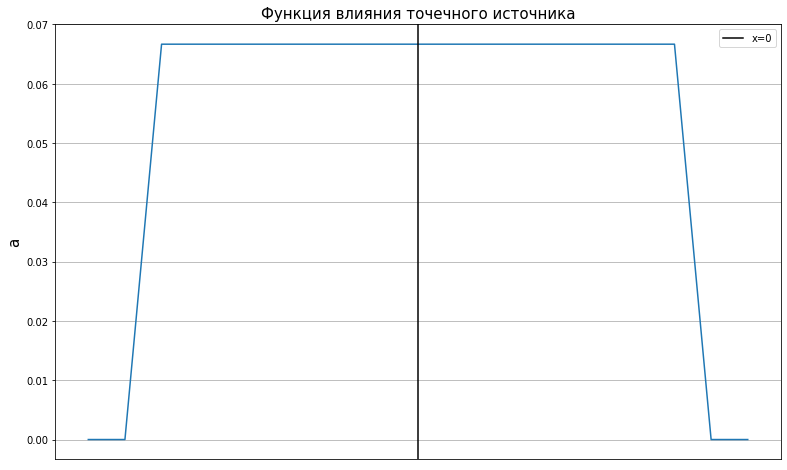

In [10]:
# график функции влияния точечного источника

fig, ax = plt.subplots(figsize=(13,8))

sns.lineplot(data = np.concatenate(([0,0], a, [0,0])), ax=ax)
ax.grid()
ax.set_ylabel('a', fontsize=15)
ax.set_title('Функция влияния точечного источника', fontsize=15)
ax.axvline(x=d+2, color='black', label='x=0')
ax.legend()
ax.set_xticks([])
plt.show()

In [11]:
# функция для построения матрицы A. Пригодится в пункте 3(c)

def make_A(M,list_with_a):
    
    al = list_with_a[0]
    ar = list_with_a[1]
    a = list_with_a[2]
    
    N = M + ar - al

    A = np.zeros((N, M))

    for j in range(M):
    
        for i in range(j, N):
        
            try:
                A[i,j] = a[i-j]
            
            except:
                A[i,j] = 0
                
    return N, A

In [12]:
# формируем матрицу A

N, A = make_A(M, get_spread_function(d))

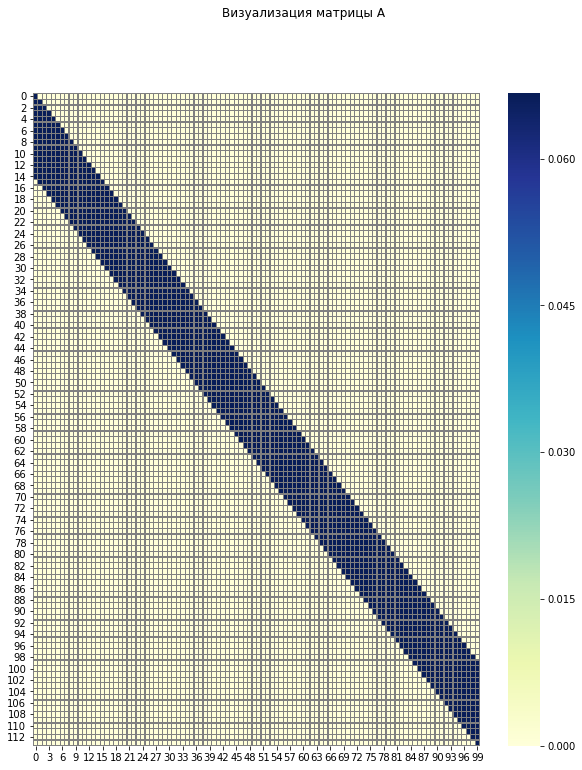

In [13]:
# визуализируем матрицу A

fig, ax = plt.subplots(figsize=(10,12))
fig.suptitle('Визуализация матрицы A')
sns.heatmap(A, cmap="YlGnBu", linewidths=.2, linecolor='grey')
plt.show()


**(c) Сформируйте результат измерения $y=Ax+\nu$**

In [14]:
# параметры шума

    # стандартное отклонение
    
s = .5

    # ковариационный оператор
    
S = np.eye(N) * s**2

In [15]:
# результат измерения

y = A @ x + s*np.random.normal(0, s, N)

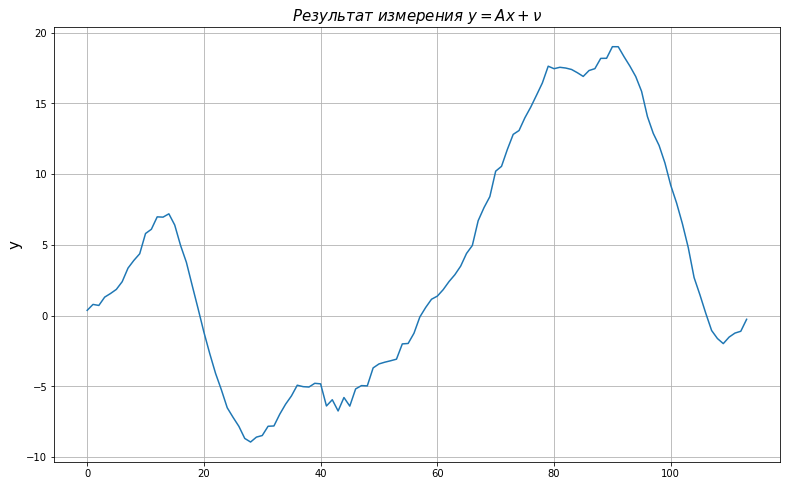

In [16]:
# график результата измерения

fig, ax = plt.subplots(figsize=(13,8))

sns.lineplot(data=y, ax=ax)
ax.grid()
ax.set_ylabel('y', fontsize=15)
ax.set_title(r'$Результат \ измерения \ y=Ax + \nu$', fontsize=15)
plt.show()

#### 2. Оценивание: Постройте оптимальную линейную оценку $\hat{x}$ и матрицу вариаций $D(\hat{x}-x)$

In [17]:
# функция для построения графика оценки

def plot_estimate (x, x_est, sigma_est, figsize=(13,8), title='Title'):
    
    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(data=x, ax=ax, label='x', linewidth=3, color='royalblue')
    sns.lineplot(data=x_est, ax=ax, label='x_est', linewidth=2, color='darkseagreen')
    plt.plot(x_est-sigma_est, label=r'$\sigma$', linewidth=1.5, color='darkseagreen', linestyle='--')
    plt.plot(x_est+sigma_est, linewidth=1.5, color='darkseagreen', linestyle='--')
    ax.grid()
    ax.legend()
    ax.set_ylabel('x', fontsize=15)
    ax.set_title(title, fontsize=15)
    plt.show()

In [18]:
# строим оптимальную линейную оценку по одному измерению без априорной оценки

F = np.linalg.inv(A.T @ np.linalg.inv(S) @ A)

x_est = F @ A.T @ np.linalg.inv(S) @ y

sigma_est = np.array([F[i,i]**0.5 for i in range(F.shape[0])])

<div class="alert alert-block alert-info">
   
Чтобы оценить, насколько хорошо оценка приближает истинный x - я использовал среднюю квадратичную ошибку   
   
</div>

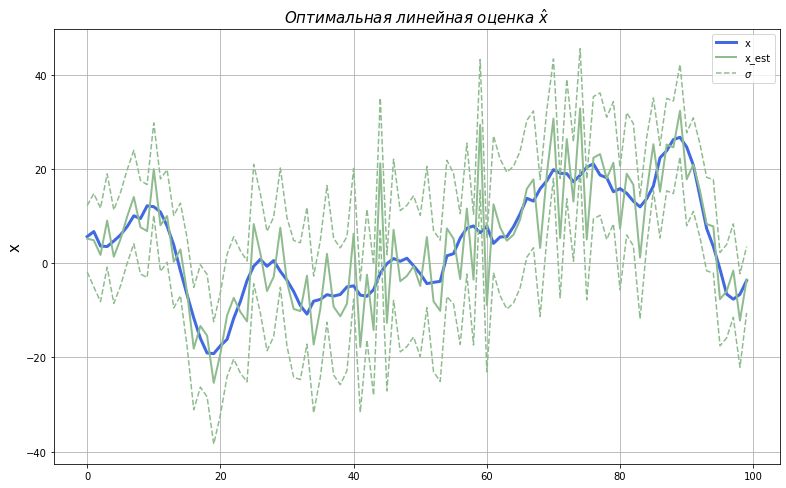

Средняя квадратичная ошибка = 7.05


In [19]:
# график результата измерения

plot_estimate (x, x_est, sigma_est, figsize=(13,8), title=r'$Оптимальная \ линейная \ оценка \ \hat{x}$')

print('Средняя квадратичная ошибка = {:.2f}'.format(MSE(x, x_est)**0.5))

**Несмотря на то, что истинная функция везду попадает в коридор одной $\sigma$, средняя квадратичная ошибка составляет 6.57**

#### 3. Проиллюстрируйте оценки для различных сит

*Формулы перехода между информацией в разных видах*:

- *сырая* $\rightarrow$ каноническая: $T=A^*S^{-1}A \ ; \  v=A^*S^{-1}y$

In [20]:
def get_canonic_from_raw(y, A, S):
    
    T = A.T @ np.linalg.inv(S) @ A
    v = A.T @ np.linalg.inv(S) @ y
    
    return T,v

- *каноническая* $\rightarrow$ явная: $F=T^{-1} \ ; \  x=T^{-1}v$

In [21]:
def get_explicit_from_canonic (T,v):
    
    F = np.linalg.inv(T)
    x = np.linalg.inv(T) @ v
    
    return F,x

- *явная* $\rightarrow$ каноническая: $T=F^{-1} \ ; \  v=F^{-1}x$

In [22]:
def get_canonic_from_explicit (F,x):
    
    T = np.linalg.inv(F)
    v = np.linalg.inv(F) @ x
    
    return T,v

In [23]:
def get_sigma(F):
    
    sigma_est = np.array([F[i,i]**0.5 for i in range(F.shape[0])])
    
    return sigma_est

In [24]:
def update_canonic(T_0, v_0, T_1, v_1):
    
    return T_0+T_1, v_0+v_1

**(a) однократное измерение $(y, A, S)$**

- Преобразуйте измерение $(y, A, S)$ в каноническую форму

In [25]:
# каноническая информация

T, v = get_canonic_from_raw(y, A, S)

- Постройте оценку, используя каноническую информацию

In [26]:
# оценка по канонической информации

F_est, x_est = get_explicit_from_canonic(T,v)
sigma_est = get_sigma(F_est)

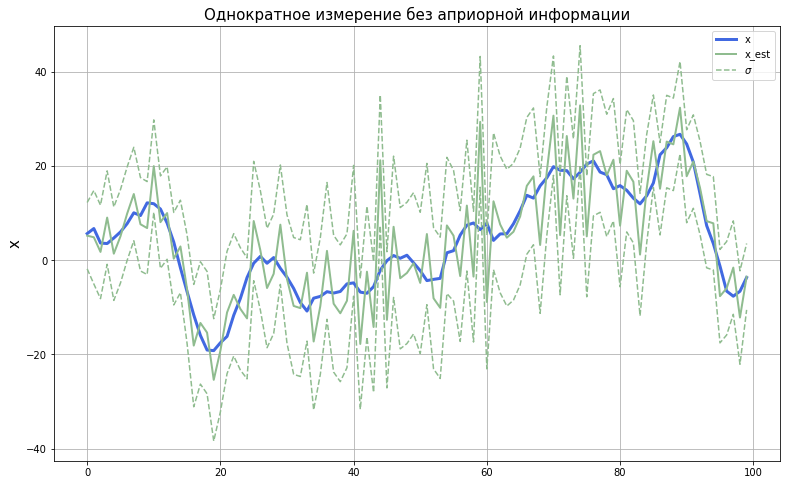

Средняя квадратичная ошибка = 7.05


In [27]:
# график оценки по канонической информации одного измерения без априорной информации

plot_estimate (x, x_est, sigma_est, figsize=(13,8), title='Однократное измерение без априорной информации')
print('Средняя квадратичная ошибка = {:.2f}'.format(MSE(x, x_est)**0.5))

**(b) однократное измерение $(y, A, S)$ с априорной информацией $x \sim (0, F)$**

- Преобразуйте априорную информацию в каноническую форму

In [28]:
# априорная информация в канонической форме

T, v = get_canonic_from_explicit(F_ap, np.zeros(M))

- Преобразуйте измерение $(y, A, S)$ в каноническую форму

In [29]:
# измерение в канонической форме

T_1, v_1 = get_canonic_from_raw(y, A, S)

- Объедините эти части канонической информации

In [30]:
# объединяем канонические информации

T, v = update_canonic(T, v, T_1, v_1)

- Постройте оценку на основе комбинированной канонической информации

In [31]:
F_est, x_est = get_explicit_from_canonic (T,v)
sigma_est = get_sigma(F_est)

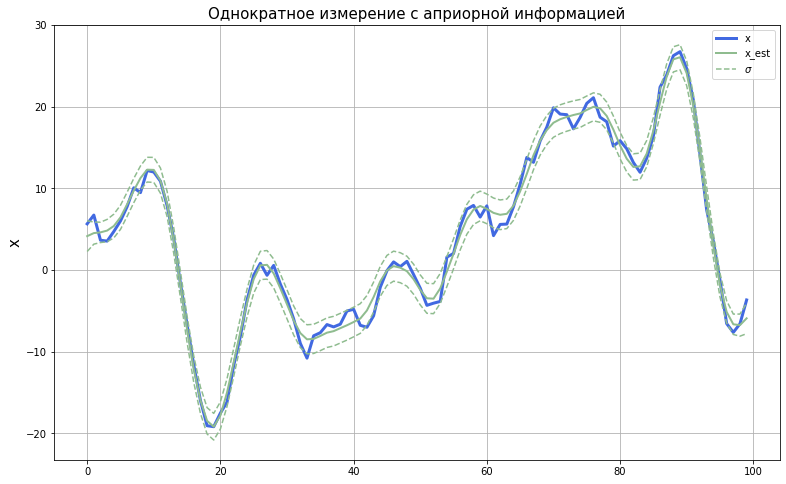

Средняя квадратичная ошибка = 1.05


In [32]:
# график оценки по канонической информации одного измерения без априорной информации

plot_estimate (x, x_est, sigma_est, figsize=(13,8), title='Однократное измерение c априорной информацией')
print('Средняя квадратичная ошибка = {:.2f}'.format(MSE(x, x_est)**0.5))

**Оценка с априорной информацией достаточно точно повторяет форму сигнала x, игнорируя только тонкую структуру. Это видно и по значительно уменьшившейся средней квадратичной ошибке**

**(c) много измерений $(y_j, A_j, S_j)$ без априорной информации**

- Смоделируйте последовательность измерений одного и того же сигнала $x$ с различными матрицами $A_j$ и $S_j$

*Для генерирования последовательности измерений $(y_j, A_j, S_j)$ будем поступать так - в цикле:*

1. Случайно генерируем функцию влияния точечного источника, с полушириной, лежащей в промежутке **[5,15]**
2. По функции влияния точечного источника строим матрицу $A_j$
3. Случайно задаем параметры шума - $\sigma_j$ в промежутке **[0.5,1.5]**
4. Получаем новое измерение  $(y_j, A_j, S_j)$

- Извлеките каноническую информацию из каждого измерения

- Объедините части канонической информации

*Для того, чтобы воспользоваться функцией **update_canonic** необходимо сначала инициировать каноническую информацию, соответствующую отсуствию информации*

In [33]:
# количество измерений

counter = 100

# каноническая информация, соответствующая отсуствию информации - нулевая матрица и нулевой вектор

T = np.zeros((M,M))
v= np.zeros(M)

for i in range(counter):
    
        # случайная полуширина функции влияния точечного источника
    
    d_i = np.random.randint(5,15)
    
        # матрица A_i
    
    N_i, A_i = make_A(M, get_spread_function(d_i))
    
        # стандартное отклонение шума
    
    s_i = .1 * np.random.randint(5,15)

        # ковариационный оператор шума
    
    S_i = np.eye(N_i) * s**2
    
        # измерение
    
    y_i = A_i @ x + s_i*np.random.normal(0, s_i, N_i)
    
        # каноническая информация
    
    T_i, v_i = get_canonic_from_raw(y_i, A_i, S_i)
    
        # обновляем каноническую информацию
        
    T, v = update_canonic(T, v, T_i, v_i)

- Постройте оценку, основанную на комбинированной канонической информации

In [34]:
# строим оценку

F_est, x_est = get_explicit_from_canonic (T,v)
sigma_est = get_sigma(F_est)

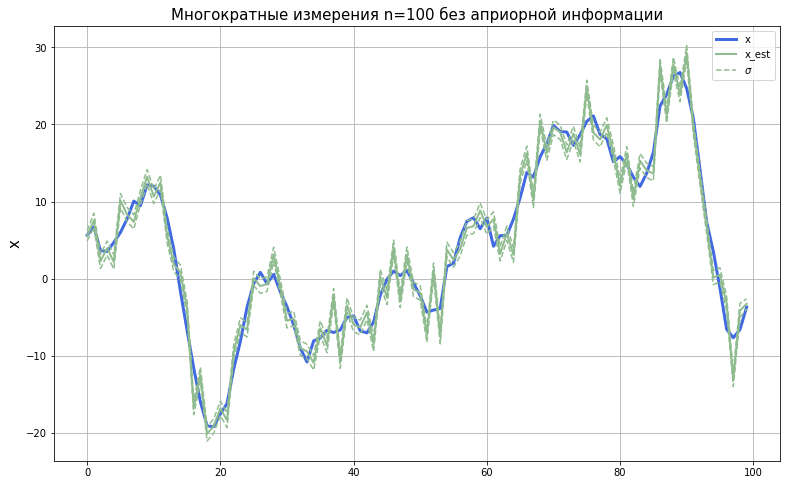

Средняя квадратичная ошибка = 2.49


In [35]:
# график оценки по канонической информации одного измерения без априорной информации

plot_estimate (x, x_est, sigma_est, figsize=(13,8), title='Многократные измерения n={} без априорной информации'.format(counter))
print('Средняя квадратичная ошибка = {:.2f}'.format(MSE(x, x_est)**0.5))

**При большом количестве измерений оценка даже без априорной функции достаточно точно повторяет форму функции, но с тонкой структурой все еще проблемы. Причем даже больше, чем при одном измерении, но с априорной информацией - можно сравнить среднюю квадратичную ошибку**

**(d) много измерений $(y_j, A_j, S_j)$ с априорной информацией**

*аналогично пункту (c), но каноническую информацию T и v в начале находим из априорной информации*

In [36]:
# количество измерений

counter = 100

# каноническая информация, соответствующая отсуствию информации - нулевая матрица и нулевой вектор

T, v = get_canonic_from_explicit(F_ap, np.zeros(M))

for i in range(counter):
    
        # случайная полуширина функции влияния точечного источника
    
    d_i = np.random.randint(5,15)
    
        # матрица A_i
    
    N_i, A_i = make_A(M, get_spread_function(d_i))
    
        # стандартное отклонение шума
    
    s_i = .1 * np.random.randint(5,15)

        # ковариационный оператор шума
    
    S_i = np.eye(N_i) * s**2
    
        # измерение
    
    y_i = A_i @ x + s_i*np.random.normal(0, s_i, N_i)
    
        # каноническая информация
    
    T_i, v_i = get_canonic_from_raw(y_i, A_i, S_i)
    
        # обновляем каноническую информацию
        
    T, v = update_canonic(T, v, T_i, v_i)

In [37]:
# строим оценку

F_est, x_est = get_explicit_from_canonic (T,v)
sigma_est = get_sigma(F_est)

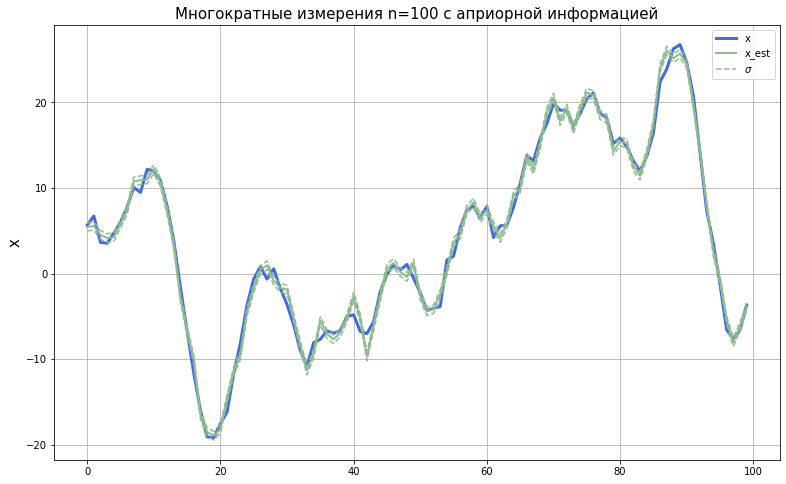

Средняя квадратичная ошибка = 0.96


In [38]:
# график оценки по канонической информации одного измерения без априорной информации

plot_estimate (x, x_est, sigma_est, figsize=(13,8), title='Многократные измерения n={} с априорной информацией'.format(counter))
print('Средняя квадратичная ошибка = {:.2f}'.format(MSE(x, x_est)**0.5))

**Большое количество измерений + априорная информация позволяют нашей оценке уловить даже тонкую структуру исходного сигнала**

---